# Verificação Facial com Redes Siamesas

Nesta tarefa, você irá construir e treinar uma rede siamesa para o problema de verificação facial. A rede irá receber um par de imagens e deverá dizer se elas foram tiradas da mesma pessoa ou de pessoas diferentes. Para isso, pedimos que você defina o modelo da sua arquitetura siamesa, carregue os dados, treine a rede e avalie sua performance no conjunto de teste.

------------
## IMPORTANTE
##### Verifique os pontos abaixo antes de começar a tarefa:
- Faça o download dos dados em https://goo.gl/yoEBsF e descomprima na mesma pasta deste notebook.
- Verifique se a pasta `INF0618-Tarefa04-faces` está no mesmo diretório deste notebook. Ela deverá conter as pastas `train`, `test`, `val` e também os arquivos `train_pairs.txt`, `test_pairs.txt` e `val_pairs.txt`. 
- Não há necessidade de alterar os códigos das sessões `Imports` e `Dataset`.
-----------


As tarefas são:

**1) Definição da arquitetura [0.25 pts]**
- Defina a arquitetura base que será utilizada em cada branch da rede siamesa;
- Defina os inputs e conecte-os a arquitetura base;
- Calcule a distância euclideana dos outputs de cada branch;

**2) Treinamento [0.25 pts]**
- Compile o seu modelo, definindo a contrastive loss e qual o otimizador que será utilizado;
- Defina também número de batches e número de épocas;
- Treine para obter a maior acurácia que vocês conseguirem;

**3) Teste [0.25 pts]**
- Avalie o conjunto de teste e reporte a loss e a acurácia normalizada;

**4) Conclusões [0.25 pts]**
- Escreva um parágrafo resumindo o que você fez, as dificuldades que encontrou, o que deu certo/errado e as suas conclusões desta atividade.

------

## Imports

In [12]:
import os
import numpy as np
from random import sample
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Convolution2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras import backend as K

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

from keras.preprocessing.image import load_img, img_to_array

# Dataset
O dataset é composto de imagens de faces em diversas condições de iluminação e expressões faciais. As imagens foram centralizadas em relação às posições dos olhos. As identidades foram divididas de forma disjunta entre os conjuntos treino/validação/teste, que contam com 37/22/8 indivíduos com número variado de imagens por identidade.

Dentro de cada conjunto, criamos todas as combinações de pares da mesma identidade (classe positiva) e limitamos a quantidade de pares de identidades diferentes (classe negativa) por este número. Dessa forma, cada conjunto está balanceado nas classes.

** IMPORTANTE NÃO ALTERAR O NOME/LOCAL DAS IMAGENS** 

In [13]:
datasetDir = "./INF0618-Tarefa04-faces"
trainPairFile = datasetDir + "/train_pairs.txt"
valPairFile = datasetDir + "/val_pairs.txt"
testPairFile = datasetDir + "/test_pairs.txt"

input_shape = (112,112,3)

def preProcessPair(line):
    img1Path, img2Path, label = line.strip().split("\t")

    img1 = img_to_array(load_img(img1Path, target_size=input_shape))
    img1 = img1.astype('float32')
    img1 /= 255.0

    img2 = img_to_array(load_img(img2Path, target_size=input_shape))
    img2 = img2.astype('float32')
    img2 /= 255.0
    
    label = int(label)
    
    return img1, img2, label
    
#Read our dataset in batches
def loadDatasetInBatches(pairFile = trainPairFile, batch_size=32):
    with open(pairFile, "r") as f:
        lines = f.readlines()
    
    while True:
        shuffledLines = sample(lines, len(lines)) #shuffle images in each epoch
        
        leftBatch, rightBatch, labelList = [], [], []
        nInBatch = 0
        
        #loop of one epoch
        for idx in list(range(len(shuffledLines))):
                        img1, img2, label = preProcessPair(shuffledLines[idx])
    
                        leftBatch.append(img1)
                        rightBatch.append(img2)
                        labelList.append(label)
                        nInBatch += 1
                        
                        #if we already have one batch, yields it
                        if nInBatch >= batch_size:
                            yield [np.array(leftBatch),np.array(rightBatch)], np.array(labelList)
                            leftBatch, rightBatch, labelList = [], [], []
                            nInBatch = 0

        #yield the remaining of the batch
        if nInBatch > 0:
            yield [np.array(leftBatch),np.array(rightBatch)], np.array(labelList)

def getDatasetSize(pairFile):
    with open(pairFile, "r") as f:
        lines = f.readlines()
    return len(lines)

               
def plotPair(img1, img2):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(121)
    ax.imshow(np.uint8(img1.reshape(input_shape)*255.0), interpolation='nearest')
    
    ax = fig.add_subplot(122)
    ax.imshow(np.uint8(img2.reshape(input_shape)*255.0), interpolation='nearest')
    plt.show()
    
trainSetSize = getDatasetSize(trainPairFile)
valSetSize = getDatasetSize(valPairFile)
testSetSize = getDatasetSize(testPairFile)

print("# pairs in Train set: ", trainSetSize)
print("# pairs in Val set: ", valSetSize)
print("# pairs in Test set: ", testSetSize)

# pairs in Train set:  245338
# pairs in Val set:  22502
# pairs in Test set:  19038


Image1 size:  (112, 112, 3) 	 Image2 size:  (112, 112, 3) 	 Label: 1


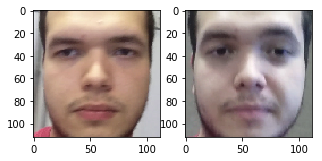

Image1 size:  (112, 112, 3) 	 Image2 size:  (112, 112, 3) 	 Label: 0


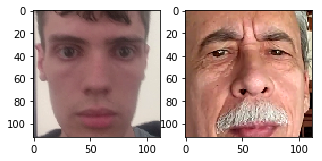

Image1 size:  (112, 112, 3) 	 Image2 size:  (112, 112, 3) 	 Label: 1


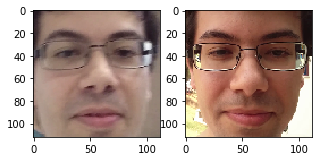

Image1 size:  (112, 112, 3) 	 Image2 size:  (112, 112, 3) 	 Label: 0


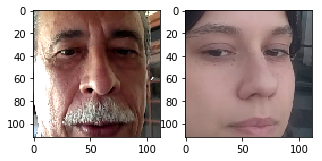

Image1 size:  (112, 112, 3) 	 Image2 size:  (112, 112, 3) 	 Label: 1


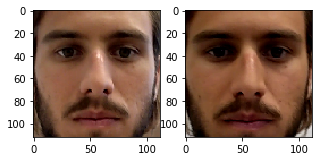

In [14]:
for batch, labels in loadDatasetInBatches(trainPairFile, batch_size=5):
    idx = 0
    leftBatch, rightBatch = batch
    for idx in list(range(leftBatch.shape[0])):
        print("Image1 size: ", leftBatch[idx].shape, "\t", "Image2 size: ", rightBatch[idx].shape,"\t Label:", labels[idx])
        plotPair(leftBatch[idx], rightBatch[idx])
    break

### Como o load do dados é feito...  
De forma parecida com o que foi feito na Tarefa03, iremos utilizar o método `loadDatasetInBatches(pairFile = trainPairFile, batch_size=32)`. Ele é um generator, ou seja, ele gera um fluxo de batches e labels a partir do nosso dataset.

**Argumentos**:
- (string) **pairFile**: se refere a qual conjunto de dados que iremos ler (treino, validação ou teste). Recebe um dos arquivos de pares definido anteriormente (trainPairFile, valPairFile, testPairFile);
- (int) **batch_size**: quantos pares por batch;

**Retorno**: 
- **batch**: retorna uma lista com 2 arrays numpy (um contendo todas as 1as imagens de cada par e outro contendo as 2as imagens de cada par). **batch** é uma lista de tamanho 2 e cada posição é array numpy com dimensões `(batch_size, 112, 112, 3)` pois são **batch_size** imagens com tamanho 112x112 e 3 canais (RGB);
- **labels**: retorna um array do numpy com as labels (1 para "mesma identidade" e 0 p/ "identidades diferentes");
    
Utilizando o argumento `pairFile`, o método lê as linhas do arquivo de pares e as embaralha (para garantir que a cada época os batches sejam diferentes). Para cada época (um loop do `for` interno), o método irá carregar um par por vez carregar e pre-processas ambas imagens. A primeira imagem do par será guardada em `leftBatch`, a segunda em `rightBatch` e a label em `labelList`.

Quando estas listas estiverem com **batch_size** elementos, teremos gerado um batch. O método dá um yield nas lista [`leftBatch`, `rightBatch`] e na `labelList` e recomeça a construção de um novo batch. Quando o `for` terminar, iremos ter completado uma época. O `while True` apenas garante uma nova época seja iniciada. Quem controlará o fim do `while` vai ser o método que fará o fit, portanto não precisamos nos preocupar com isso.  

-----------
-----------
-----------
** -----> A tarefa começa aqui !!! Vocês não precisam modificar nada dos códigos acima!** 

# Definição da arquitetura siamesa [0.25 pts]
- Defina a arquitetura base que será utilizada em cada branch da rede siamesa;
- Defina os inputs e conecte-os a arquitetura base;
- Calcule a distância euclideana dos outputs de cada branch;

In [15]:
#Compute the euclidean distance of two arrays
# funcao distancia euclidiana
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

#Defina sua arquitetura

#Base network to be shared (eq. to feature extraction).
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Convolution2D(10, (3,3), activation='relu')(input)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.25)(x)
    x = Convolution2D(20, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)


# network definition
base_network = create_base_network((input_shape))

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Calculate the euclidean distance of the two arrays
distance = Lambda(euclidean_distance)([processed_a, processed_b])

# Define final model
model = Model([input_a, input_b], distance)

# Treinamento [0.25 pts]
- Compile o seu modelo, definindo a contrastive loss e qual o otimizador que será utilizado;
- Defina também número de batches e número de épocas;
- Treine para obter a maior acurácia que vocês conseguirem;

Da mesma forma que na Tarefa03, iremos utilizar o `fit_generator` para otimizar nossa rede. Ele recebe um generator (que será fornecido pelo `loadDatasetInBatches`). Como o generator retorna um fluxo de batches/labels, o `fit_generator` não tem informação sobre o tamanho dataset. Por isso, precisamos informar o número de épocas (parâmetro `epochs`) e também quantos batches compõe uma época (parâmetro `steps_per_epoch`). Ao total, teremos 2 generators, um para o conjunto de treino e outro para o conjunto de validação.

Para mais informações sobre o fit_generator e seus parâmetros, [acesse a documentação do Keras](https://keras.io/models/sequential/#fit_generator).

In [16]:
#Compile o modelo / Defina a loss 

# accuracy function
#Compute classification accuracy with a fixed threshold on distances.
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

# funcao de perda (loss function)
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


# Compilation
# otimizador: adam
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy])

In [17]:
#Definir tamanho do batch e número de épocas
batch_size = 32
epochs = 2

#Criação dos generators
trainGenerator = loadDatasetInBatches(trainPairFile, batch_size = batch_size)
valGenerator = loadDatasetInBatches(valPairFile, batch_size = batch_size)

#Fit nos dados
model.fit_generator(trainGenerator, 
                    steps_per_epoch= int(trainSetSize / batch_size), 
                    epochs = epochs,
                    validation_data = valGenerator,  
                    validation_steps = int(valSetSize / batch_size))

Epoch 1/2
7666/7666 [==============================] - 10577s 1s/step - loss: 0.0463 - accuracy: 0.9556 - val_loss: 0.1993 - val_accuracy: 0.6954
Epoch 2/2
7666/7666 [==============================] - 9835s 1s/step - loss: 0.0223 - accuracy: 0.9868 - val_loss: 0.1972 - val_accuracy: 0.7108


# Teste [0.25 pts]
O teste será feito da mesma forma, utilizando `loadDatasetInBatches` para o conjunto de teste. 

In [18]:
#Criação do generator p/ o conjunto de teste
testGenerator = loadDatasetInBatches(testPairFile, batch_size=batch_size)

#Teste
metrics = model.evaluate_generator(testGenerator, 
                                   steps=int(testSetSize/batch_size), 
                                   verbose=1)

print("Test Loss ---> ", metrics[0])
print("Test Accuracy ---> ", metrics[1])    #Test is balanced, so Acc is normalized

594/594 [==============================] - 404s 680ms/step
Test Loss --->  0.16464088741777722
Test Accuracy --->  0.751473063973064


# Conclusões  [0.25 pts]
Escreva um parágrafo com as conclusões que você tirou na tarefa. Comente as dificuldades encontradas, as tentativas feitas, como foi o seu treinamento, apontando a motivação pelas decisões tomadas. Se o resultado ficou melhor/pior do que o que você esperava, o que você acha que pode ter acontecido?

Para essa tarefa, foi treinada uma rede siamesa para o problema de verificação facial. A rede recebe um par de imagens e deverá dizer se elas foram tiradas da mesma pessoa ou de pessoas diferentes. O principal conceito da rede siamesa (estudado nessa atividade) é a de aprender uma função de similaridade entre duas imagens, de forma a consegui computar através de duas (ou mais, dependendo do problema) redes neurais com os mesmos parâmetros aprendidos durante o treinamento a calcular essa função de similaridade e conseguir decidir se as duas imagens (fotos de pessoas, assinaturas, etc) são ou não da mesma pessoa.


Foi criada a seguinte arquitetura de rede:

Uma camada convolucional 2d com kernels 3x3 e com ativação relu.
Uma camada de max pooling 2d.
Dropou com 25% de probabilidade
Outra camada convolucional 2d com kernels 3x3 e com ativação relu.
Outra camada de max pooling 2d.
Uma camada flatten para transformar 2d em 1d
Uma camada de dropout com 30% de probabilidade, para previnir overfitting do modelo
Uma camada dense de 128, com ativação relu

Foram utilizadas duas camadas de dropout com probabilidade para reduzir a chance de overfitting. O resultado se mostrou melhor do que utulizando somente dropou na última camada. A learning rate escolhida é a padrão para o otimizador adam. A função de perda foi definida por nós e chamada de contrastive_loss, e o optimizer foi o adam, como de costume. A métrica de avaliação escolhida foi a acurácia. Foram utilizadas somente 2 épocas por restrições de poder computacional e tempo, mas seria possível treinar por mais épocas para ter resultados melhores desde que fosse minitorata a acurácia no conjunto de validação ao longo do treinamento para que não aconteça overfitting.


Os resultados obtidos foram:

Train Loss: 0.0223

Train Accuracy: 0.9868

Val Loss: 0.1972

Val Accuracy: 0.7108

Test Loss: 0.1646

Test Accuracy: 0.7514

As acurácias tanto para treino, teste e validação obtidas foram muito boas. É interessante notar que, mesmo no fim da primeira época, o modelo já apresentava ótimos resultados, conseguindo resolver o problema proposto de forma eficiente. Na segunda época o modelo melhorou um pouco mais. Isso mostra que as redes siamesas são excelentes para resolver o tipo de problema proposto (reconhecimento facial e aprendizado de uma função de similaridade entre duas imagens). Contudo, é possível afirmar que ocorreu um pouco de overfitting, pois os resultados para validação e testes são muito menores do que para o treino. Possivelmente seria possível resolver parte do problema com Data Augmentation e mais camadas de dropout e regularização.

Uma dificuldade grande dificuldade inicial (comentada com o monitor da disciplina), foi que eu demorei muitas horas para conseguir sincronizar as pastas física do windows e virtual do docker com o conteúdo desejado, de modo que demorei muito tempo para conseguir enviar as imagens para o diretório correto e iniciar a análise.

Também tive uma grande dificuldade envolvendo poder e tempo de processamento, pois a capacidade de processamento do meu laptop pessoal é muito abaixo do esperado. Demorou em torno de 8 horas para o meu modelo compilar.